# **Introduction**
***In this notebook we will explorer timeseries of communication between local computer(l_ipn) and remote resource(r_asn). Available dataset gives per day aggregate connections count between l_ipn and r_asn for each l_ipn. This notebook uses open source forceasting and anomaly detection libraries such as Prophet(https://facebook.github.io/prophet/docs/quick_start.html) and luminol https://github.com/linkedin/luminol. Objective of this notebook is to see if these libraries can be used to predict abnormal traffic pattern. If you would like to know general information about bots please follow this on wikipedia https://en.wikipedia.org/wiki/Botnet***

# **Notebook**

***Let's get started with notebook by reading datafile and  importing required packages***

In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/computer-network-traffic/cs448b_ipasn.csv


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import to_datetime
from fbprophet import Prophet

In [74]:
df = pd.read_csv('/kaggle/input/computer-network-traffic/cs448b_ipasn.csv')

# Data Exploration

In [75]:
print('dataframe shape {} '.format(df.shape))

dataframe shape (20803, 4) 


In [76]:
print(df.head(10))

         date  l_ipn  r_asn   f
0  2006-07-01      0    701   1
1  2006-07-01      0    714   1
2  2006-07-01      0   1239   1
3  2006-07-01      0   1680   1
4  2006-07-01      0   2514   1
5  2006-07-01      0   3320   1
6  2006-07-01      0   3561  13
7  2006-07-01      0   4134   3
8  2006-07-01      0   5617   2
9  2006-07-01      0   6478   1


***Each row of dataset shows aggregate connection between l_ipn and r_asn on a day, for example row 0 in dataset says on date 2006-07-01 l_ipn 0 and r_asn 701 has one flow. Similarly row 6 indicate there were 13 flows or connections between l_ipn 0 and r_asn 3561. Lets look at the brief descriptive statistics and clean up missing data***

In [77]:
print('Number of days for which data is available {:d}'.format(df['date'].nunique()))
print('Unique local ip {:d}'.format(df['l_ipn'].nunique()))
print('Unique remote ASN {:d}'.format(df['r_asn'].nunique()))
print('Minimum flow count per day {:d}'.format(df['f'].min()))
print('Maximum flow count per day {:d}'.format(df['f'].max()))

Number of days for which data is available 92
Unique local ip 10
Unique remote ASN 2005
Minimum flow count per day 1
Maximum flow count per day 784234


In [78]:
#Missing or NAN values in dataset
df.isnull().sum()

date     0
l_ipn    0
r_asn    0
f        0
dtype: int64

Along with dataset it is mentioned

Reports of "odd" activity or suspicions about a machine's behavior triggered investigations on the following days (although the machine might have been compromised earlier)
Date : IP <br>
08-24 : 1 <br>
09-04 : 5 <br>
09-18 : 4 <br>
09-26 : 3 6 <br>

We will keep this information in dataframe for visualisation in diffrent charts

In [79]:
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


***To understand connections represented in the dataset, lets look at the connection flow aggregated across all L_ipn and r_asn over for each day***

In [80]:
#Aggregating daily connections
daily_aggregate = df.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)

In [81]:
daily_aggregate[['f']].describe()

,f
count,92.000000
mean,21235.847826
std,85752.692609
min,2706.000000
25%,5211.750000
50%,8773.500000
75%,12426.000000
max,788297.000000


In [82]:
daily_mean = round(daily_aggregate['f'].mean(),2)

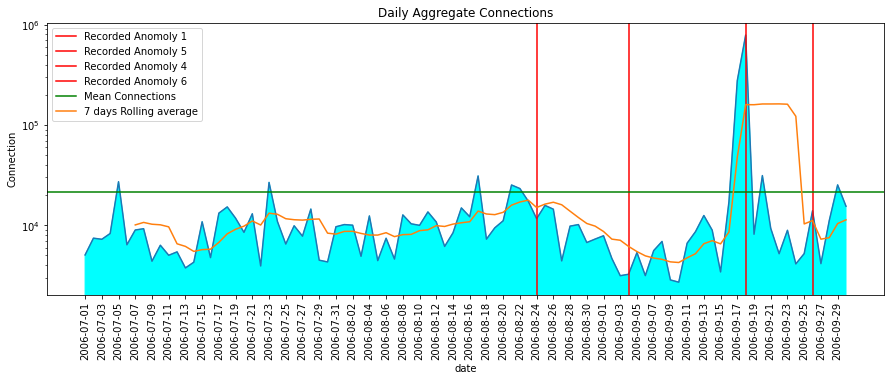

In [83]:
plt.figure(figsize=(15,5))
plt.plot(daily_aggregate['date'],daily_aggregate['f'])
[plt.axvline(x=_x, color='r' , label = 'Recorded Anomoly {}'.format(ip)) for _x,ip in list(marked_anomalies[['date','l_ipn']].to_records(index=False))]
plt.axhline(y= daily_mean, color='g', label = 'Mean Connections')
plt.plot(daily_aggregate['date'],daily_aggregate['f'].rolling(7).mean(), label = '7 days Rolling average')
plt.xticks(daily_aggregate['date'][::2],  rotation='vertical')
plt.yscale('log')
plt.xlabel('date')
plt.ylabel('Connection')
plt.title('Daily Aggregate Connections')
plt.fill_between(daily_aggregate['date'],daily_aggregate['f'],color='aqua')
plt.legend()
plt.show()

In [84]:
daily_aggregate_l_ipn = df.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)

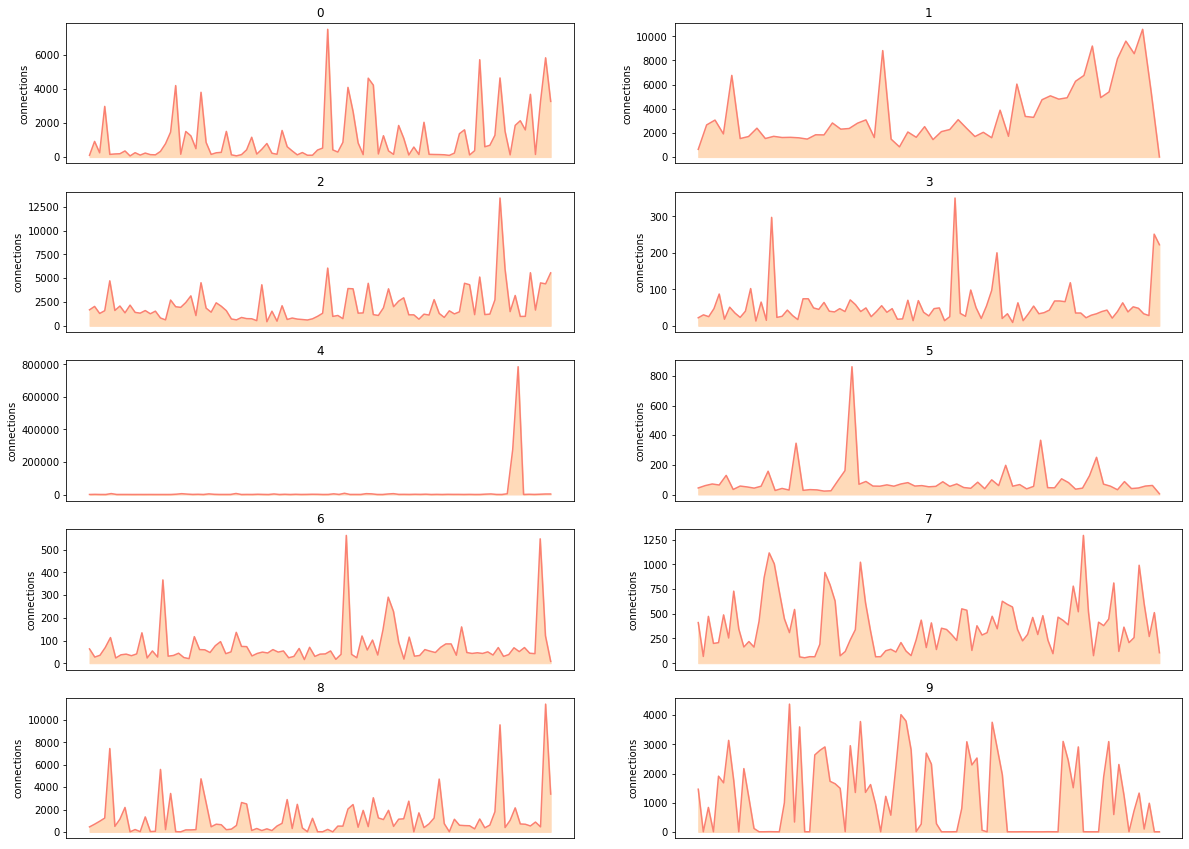

In [89]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))

plot_row = 0
plot_col = 0

for i in range(df['l_ipn'].nunique()):
    temp = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == i]
    axes[plot_row,plot_col].set_title(i)
    axes[plot_row,plot_col].set_xlabel('date')
    axes[plot_row,plot_col].set_ylabel('connections')
    
    axes[plot_row,plot_col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    axes[plot_row,plot_col].plot(temp['date'],temp['f'], color = 'salmon')
    axes[plot_row,plot_col].get_xaxis().set_visible(False)
    axes[plot_row,plot_col].fill_between(temp['date'],temp['f'], color='peachpuff')
    

    plot_col = plot_col + 1
    if(plot_col == 2):
        plot_row = plot_row + 1
        plot_col = 0
plt.show()

*Aggregating flows on per r_asn*

In [90]:
daily_aggregate_r_asn = df.groupby(['r_asn'])[['f']].sum()
daily_aggregate_r_asn.reset_index(inplace = True)

In [93]:
pd.options.display.float_format = '{:.2f}'.format
daily_aggregate_r_asn['f'].describe()

count      2005.00
mean        974.41
std       23862.63
min           1.00
25%           2.00
50%           8.00
75%          43.00
max     1059254.00
Name: f, dtype: float64

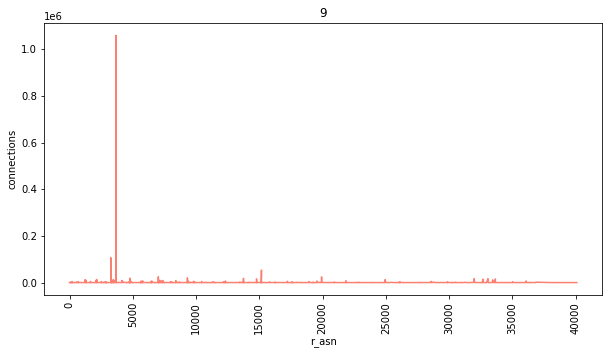

In [97]:
plt.figure(figsize=(10,5))
plt.title(i)
plt.xlabel('r_asn')
plt.ylabel('connections')
plt.xticks(rotation='vertical')
#n_bins =  daily_aggregate_r_asn['r_asn']
#plt.hist(daily_aggregate_r_asn['f'], n_bins, histtype ='bar')
plt.plot(daily_aggregate_r_asn['r_asn'],daily_aggregate_r_asn['f'], color = 'salmon')
plt.show()

# *Anomaly detection using Prophet library*

In [ ]:
def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_df = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['ds','y']
    temp_df['ds'] = to_datetime(temp_df['ds'])
    temp_df.reset_index(inplace=True,drop=True)
    return temp_df

In [ ]:
def get_forecast(ts,in_l_ipn):
    
    model = Prophet(seasonality_mode='additive',daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True)
    model.fit(ts)
    forecast = model.predict(pd.DataFrame(ts['ds']))
    
    ts['anomaly'] = 0
    p_color = np.full((ts.shape[0],1),'green')
    for i in range(forecast.shape[0]):
        if((forecast.at[i,'yhat_lower'] > ts.at[i,'y']) or (forecast.at[i,'yhat_upper'] < ts.at[i,'y'])):
            ts.at[i,'anomaly'] = 1
            p_color[i] = 'red'
                
    model.plot(forecast)
    
    plt.scatter(ts['ds'],ts['y'],c=p_color.ravel())
    plt.title('Forcast plot for l_ipn %d' %in_l_ipn)
    plt.show()


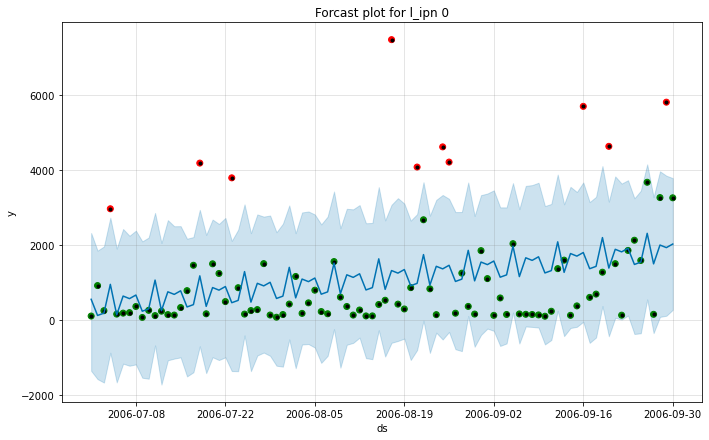

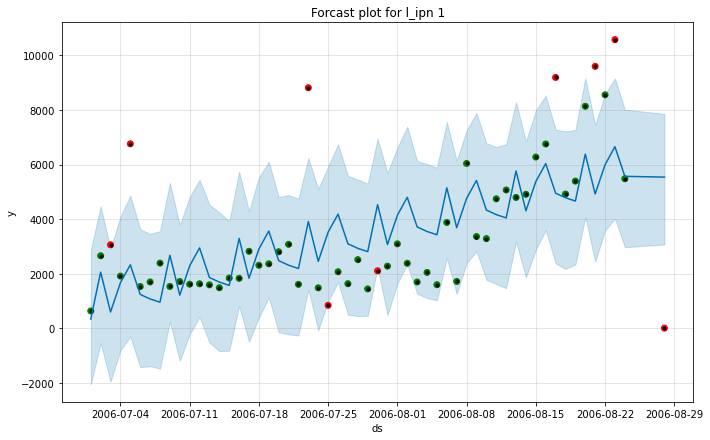

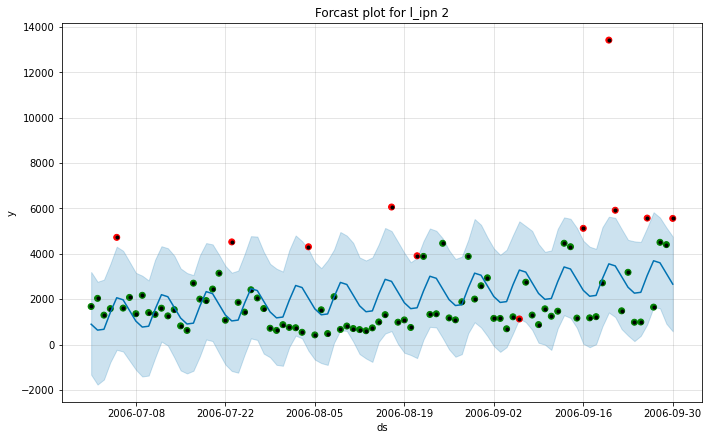

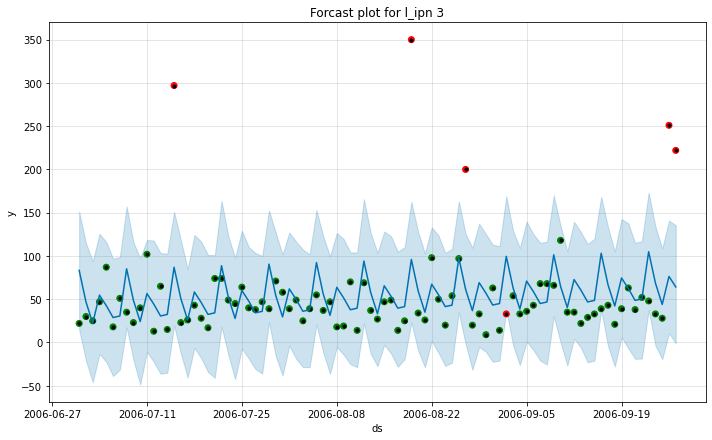

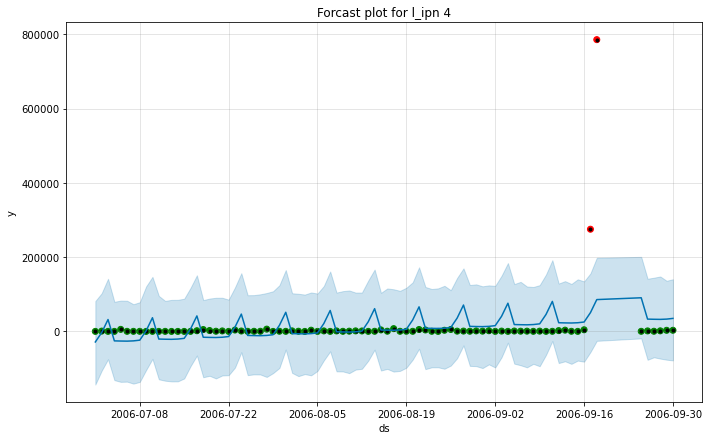

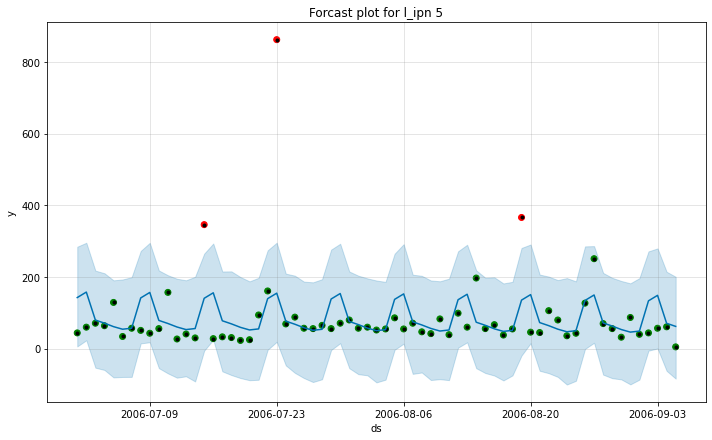

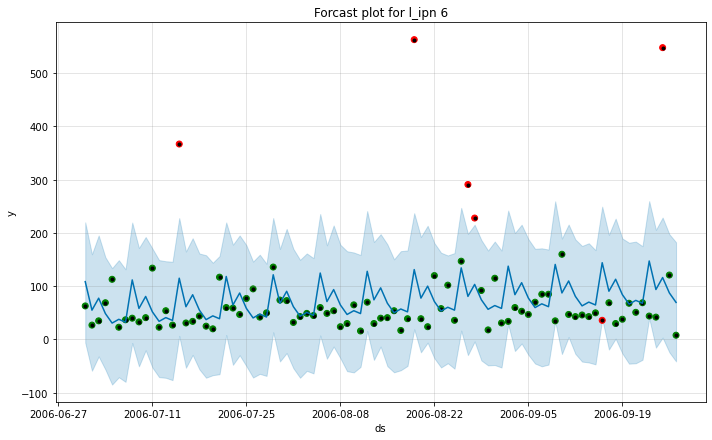

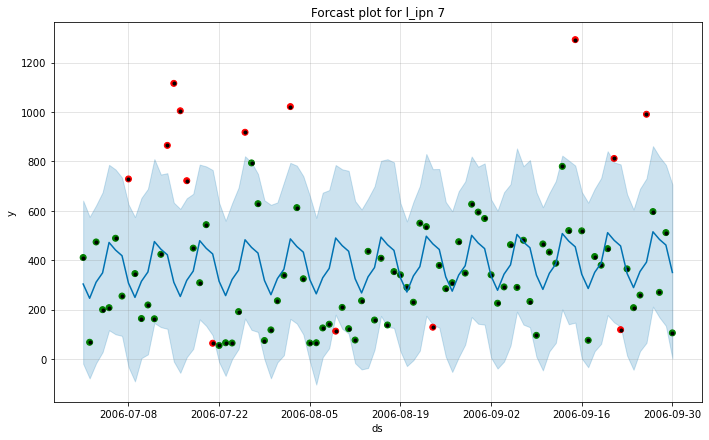

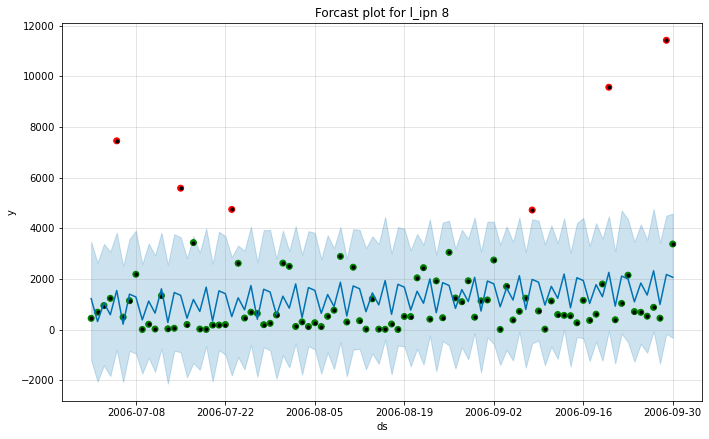

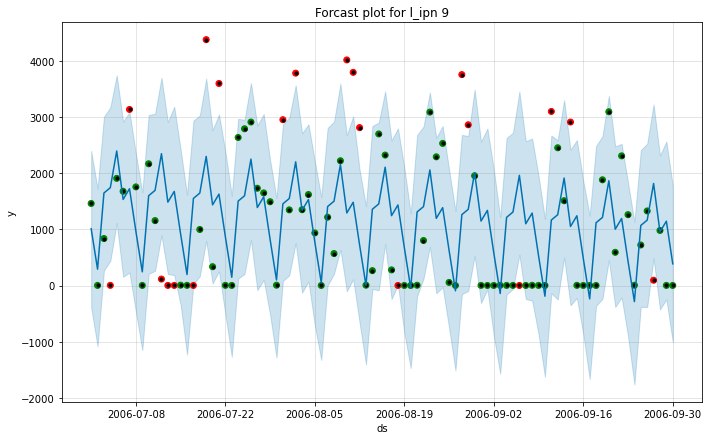

In [98]:
for i in range(df['l_ipn'].nunique()):
    get_forecast(get_daily_aggregate_l_ipn(i),i)

*Red dots in the graph are out of forecast so these points can be considered as anomaly*

# Anomaly detection using luminol

In [99]:
pip install luminol

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [100]:
import luminol
from luminol.anomaly_detector import AnomalyDetector

In [101]:
def get_luminol_anomalies(in_df):
    in_df['isAnomaly'] = 0
    detector = AnomalyDetector(in_df['y'].to_dict())
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            in_df.at[k,'isAnomaly'] = 1     
    return(in_df)    

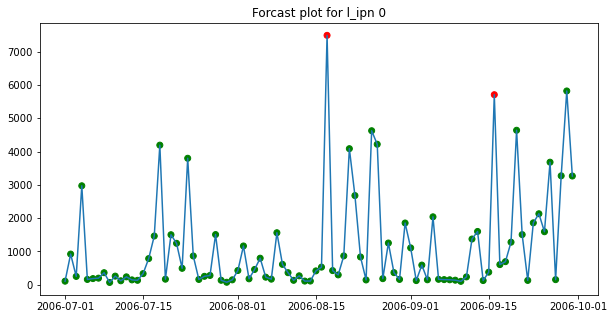

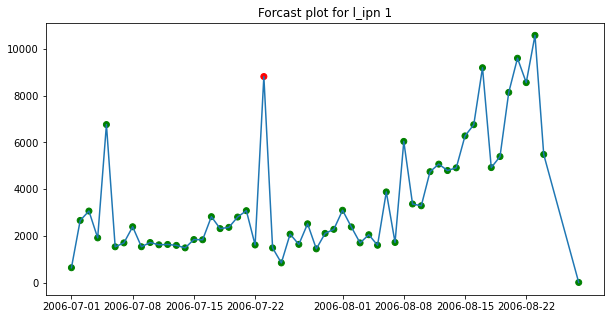

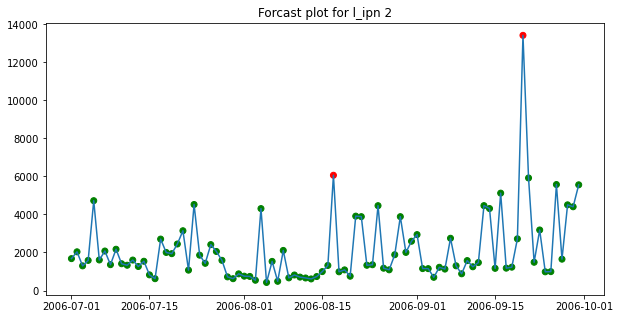

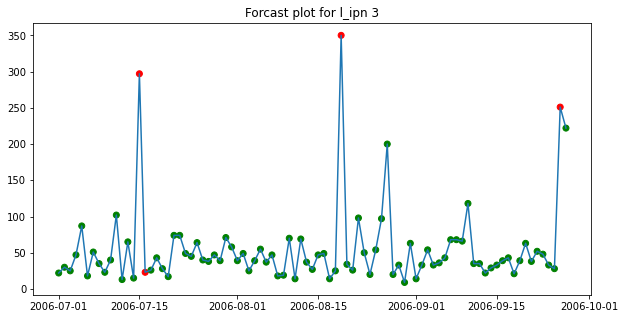

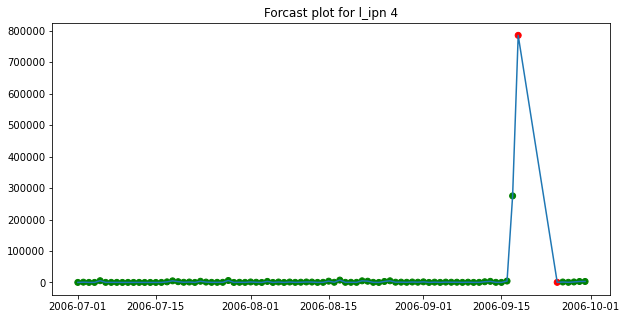

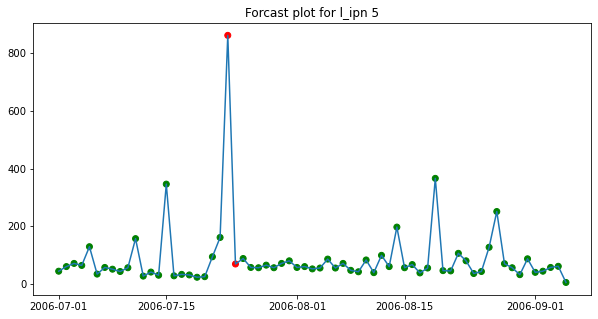

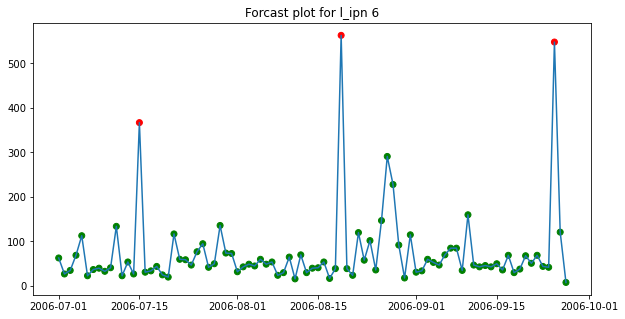

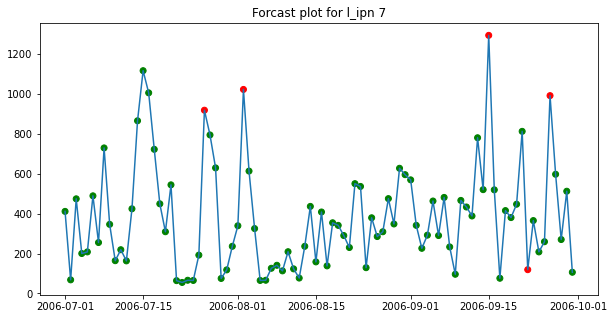

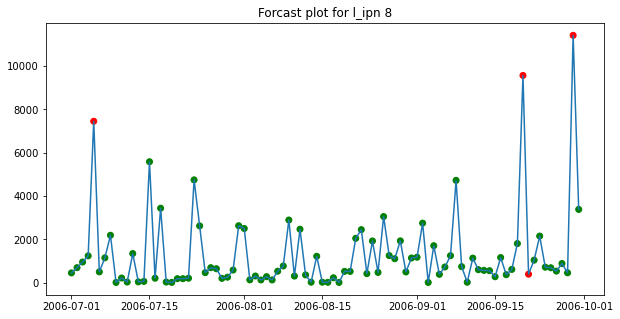

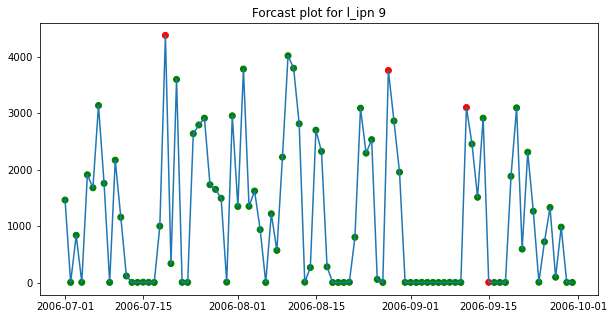

In [102]:
for i in range(df['l_ipn'].nunique()):
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i))
    
    colors = {0:'green', 1:'red'}
   
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'])
    plt.scatter(t_df['ds'],t_df['y'],c=t_df['isAnomaly'].apply(lambda x: colors[x]))
    plt.title('Forcast plot for l_ipn %d' %i)
    plt.show()

*Anomalies are marked by red dots in graph*